El Dataset de Transacciones con Tarjetas de Crédito proporciona registros detallados de transacciones con tarjetas de crédito, incluyendo información sobre los tiempos de transacción, montos, y detalles personales y del comerciante asociados.

In [1]:
#Importación librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point

#Lectura y muestra de dataset
df = pd.read_csv('credit_card_transactions.csv')
df.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


Hipótesis
1) Las transacciones fraudulentas tienden a ocurrir en ciertas categorías de tiendas o tipos de transacciones (por ejemplo, entretenimiento, electrónica).
2) Las transacciones fraudulentas tienden a ocurrir en áreas geográficas específicas o con una densidad poblacional específica.
3) Las transacciones fraudulentas tienden a ocurrir en días y horarios específicos
4) Los comerciantes que tienen una alta densidad de transacciones tienden a tener una menor tasa de fraudes.
5) Las transacciones de titulares jóvenes son más susceptibles a fraudes.

Hipótesis 1: Las transacciones fraudulentas tienden a ocurrir en ciertas categorías de tiendas o tipos de transacciones.

Proporción de transacciones fraudulentas por categoría
- Variables: category, fraud_ratio, total_count
- Propósito: Visualizar la proporción de transacciones fraudulentas en relación con el total de transacciones por categoría de comercio.

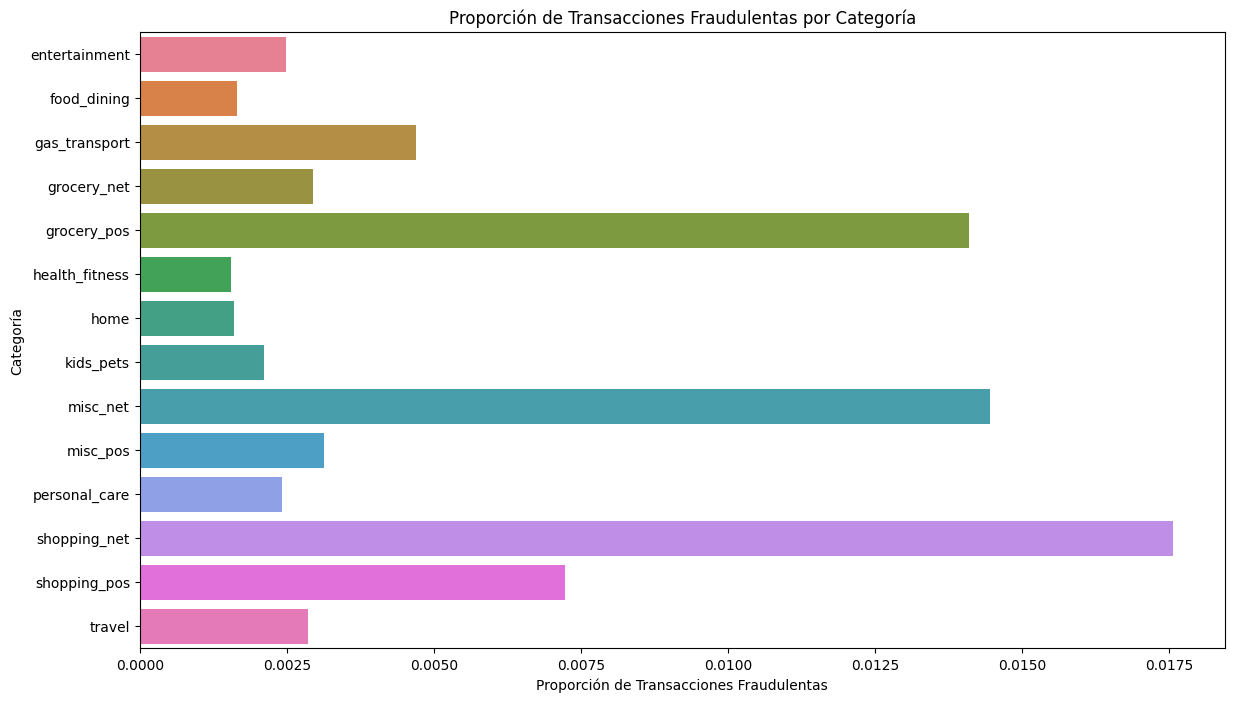

In [2]:
category_counts = df.groupby('category').size().reset_index(name='total_count')
fraud_counts = df[df['is_fraud'] == 1].groupby('category').size().reset_index(name='fraud_count')
category_df = pd.merge(category_counts, fraud_counts, on='category', how='left').fillna(0)
category_df['fraud_ratio'] = category_df['fraud_count'] / category_df['total_count']

# Gráfico
plt.figure(figsize=(14, 8))
sns.barplot(x='fraud_ratio', y='category', data=category_df, hue='category', dodge=False)
plt.title('Proporción de Transacciones Fraudulentas por Categoría')
plt.xlabel('Proporción de Transacciones Fraudulentas')
plt.ylabel('Categoría')
plt.show()


Categorías con Mayor Proporción de Fraudes:
- shopping_net (compras en línea)
- misc_net (transacciones misceláneas en línea)
- grocery_pos (puntos de venta de comestibles)

Categorías con Menor Proporción de Fraudes:
- home (artículos para el hogar)
- personal_care (cuidado personal)
- health_fitness (salud y fitness)

Hipótesis 2: Las transacciones fraudulentas tienden a ocurrir en áreas geográficas específicas o con una densidad poblacional específica.

Mapa de tasa de fraudes por zona geográfica
- Variables: lat, long, is_fraud
- Propósito: Visualizar la distribución geográfica de las transacciones fraudulentas para identificar áreas más propensas a fraudes.

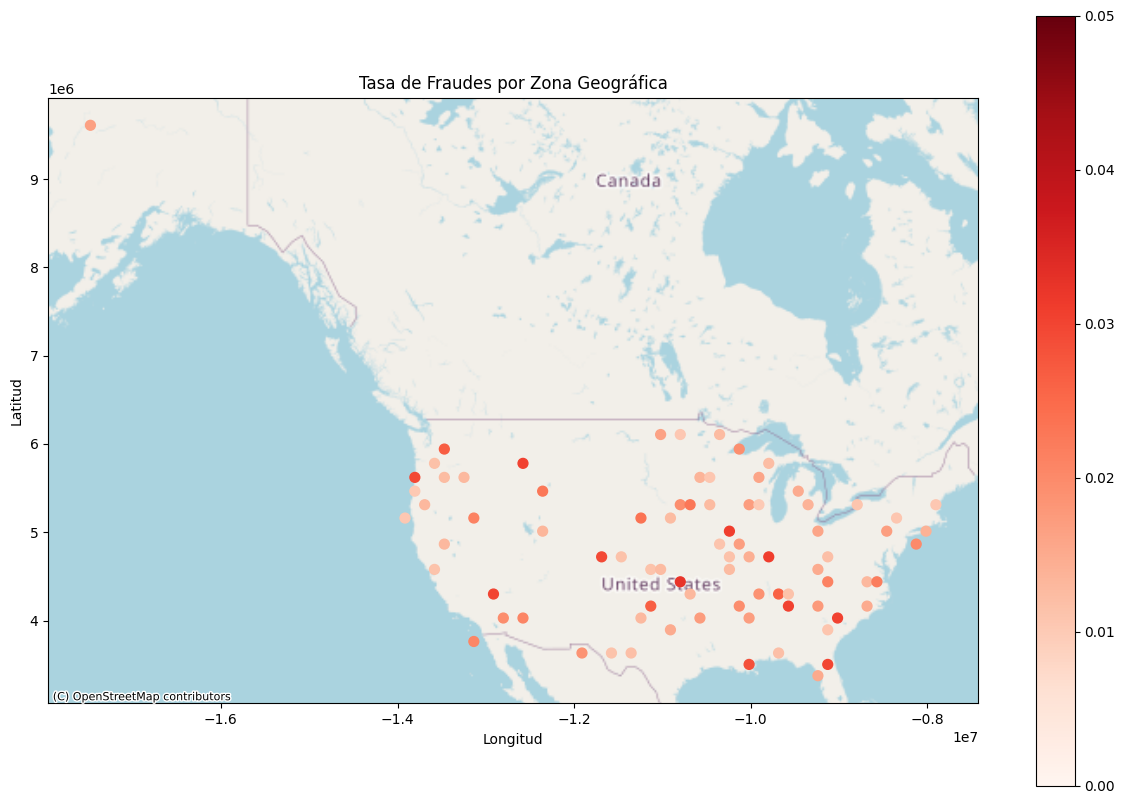

In [3]:
#Tamaño de las celdas
grid_size = 1.0
df['lat_bin'] = np.floor(df['lat'] / grid_size) * grid_size
df['long_bin'] = np.floor(df['long'] / grid_size) * grid_size

#Transacciones totales y fraudes por celda
grouped = df.groupby(['lat_bin', 'long_bin']).agg(total_trans=('is_fraud', 'size'), fraud_trans=('is_fraud', 'sum')).reset_index()
grouped['fraud_rate'] = grouped['fraud_trans'] / grouped['total_trans']

#Filtro de celdas
filtered_grouped = grouped[(grouped['total_trans'] > 100) & (grouped['fraud_rate'] > 0.01)]

#Mapa
geometry = [Point(xy) for xy in zip(filtered_grouped['long_bin'], filtered_grouped['lat_bin'])]
geo_grouped = gpd.GeoDataFrame(filtered_grouped, geometry=geometry, crs="EPSG:4326")
geo_grouped = geo_grouped.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(15, 10))
geo_grouped.plot(ax=ax, column='fraud_rate', cmap='Reds', markersize=50, legend=True, vmin=0, vmax=0.05)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title('Tasa de Fraudes por Zona Geográfica')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

Conclusiones:
- Observamos que hay ciertos puntos en los Estados Unidos donde la tasa de fraude es relativamente más alta. Estas áreas están representadas con puntos más grandes y de color más oscuro en el mapa. Específicamente, se pueden observar tasas de fraude más altas en algunas partes del centro y el sureste de los Estados Unidos.
- La distribución de los fraudes no es uniforme a lo largo del país. Hay regiones con un alto volumen de transacciones, pero con tasas de fraude relativamente bajas, y otras con menos transacciones, pero con tasas de fraude más elevadas. Las zonas con mayor concentración de fraudes tienden a estar más dispersas y no parecen seguir un patrón geográfico claramente definido.

Hipótesis 3: Las transacciones fraudulentas tienden a ocurrir en días y horarios específicos.

Mapa de calor
- Variables: hour, day_of_week, is_fraud
- Propósito: Identificar patrones temporales en la ocurrencia de fraudes.

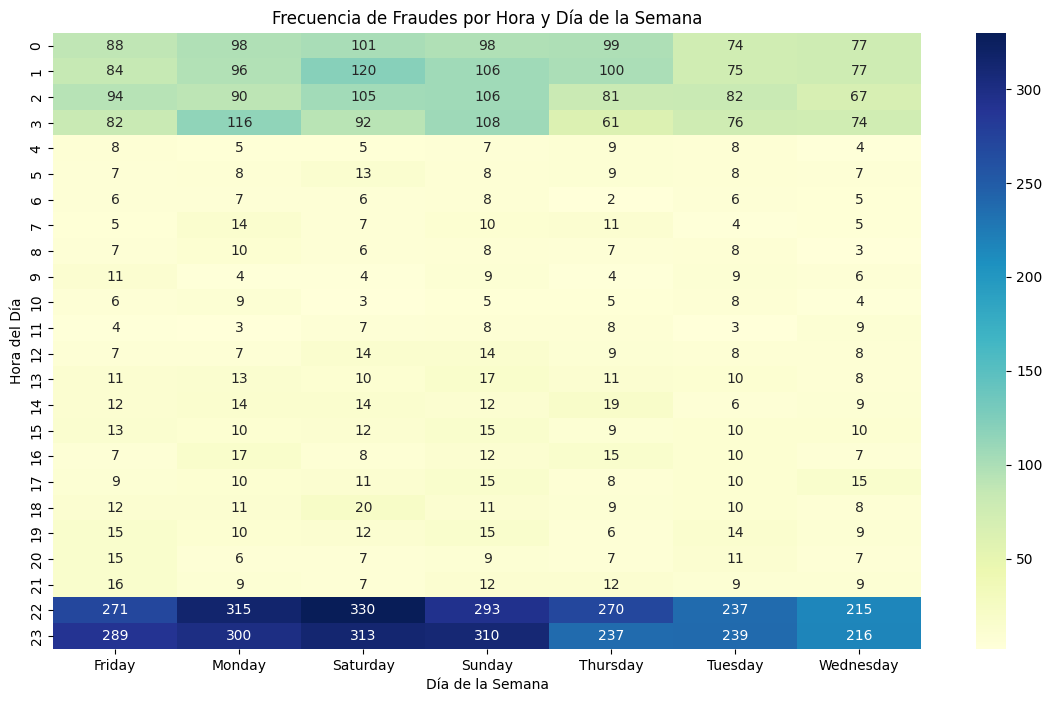

In [4]:
df['hour'] = pd.to_datetime(df['trans_date_trans_time']).dt.hour
df['day_of_week'] = pd.to_datetime(df['trans_date_trans_time']).dt.day_name()

fraud_heatmap = pd.crosstab(df['hour'], df['day_of_week'], values=df['is_fraud'], aggfunc='sum').fillna(0)

plt.figure(figsize=(14, 8))
sns.heatmap(fraud_heatmap, cmap='YlGnBu', annot=True, fmt='g')
plt.title('Frecuencia de Fraudes por Hora y Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Hora del Día')
plt.show()

Conclusiones:
- Las horas más activas en términos de fraudes parecen ser desde medianoche hasta aproximadamente las 4 AM, donde se observa una mayor concentración de celdas en tonos más oscuros, indicando un mayor número de fraudes.
- Se observa un patrón interesante donde viernes, lunes, sábado y domingo presentan los números más altos de fraudes en comparación con los otros días de la semana.
- Durante el día, específicamente entre las 6 AM y las 8 PM, la actividad fraudulenta es significativamente menor, como se muestra en las celdas más claras del heatmap.

Hipótesis 4: Los comerciantes que tienen una alta densidad de transacciones tienden a tener una menor tasa de fraudes.

Relación entre volumen de transacciones y tasa de fraudes por comerciante
- Variables: merchant, amt, is_fraud
- Propósito: Identificar si existe una correlación entre el volumen de transacciones y la seguridad relativa (medida por la tasa de fraudes) de los comerciantes.

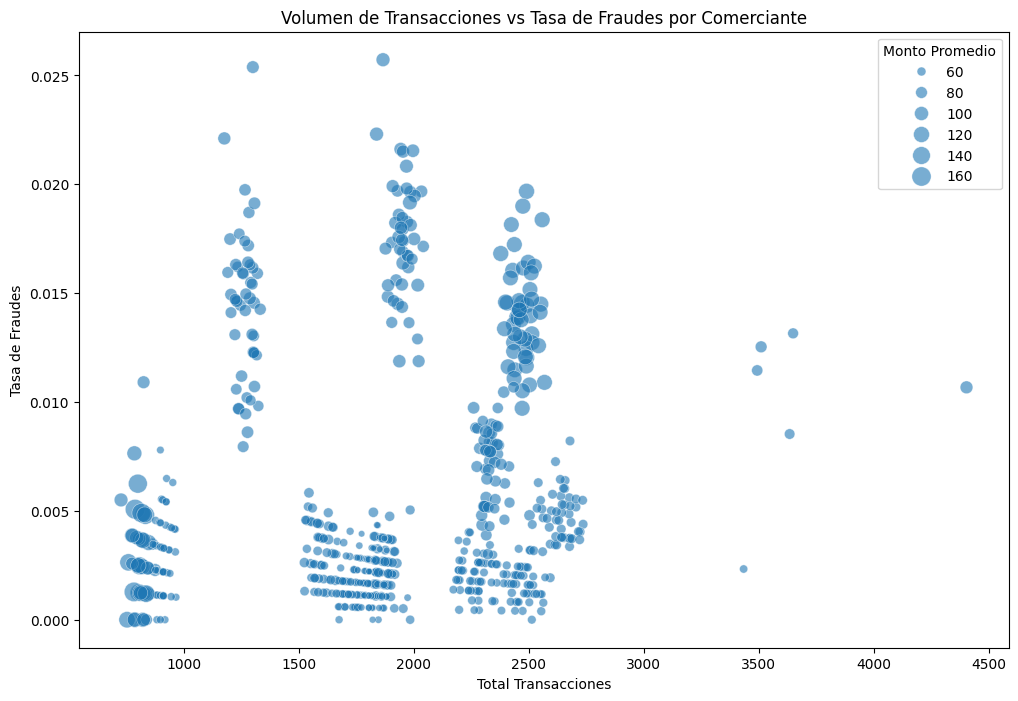

In [5]:
#Transacciones y fraudes por comerciante
merchant_counts = df.groupby('merchant').agg(total_trans=('merchant', 'size'), fraud_count=('is_fraud', 'sum')).reset_index()
merchant_counts['fraud_rate'] = merchant_counts['fraud_count'] / merchant_counts['total_trans']
merchant_counts['avg_amt'] = df.groupby('merchant')['amt'].mean().reset_index(drop=True)

# Gráfico
plt.figure(figsize=(12, 8))
sns.scatterplot(x='total_trans', y='fraud_rate', size='avg_amt', data=merchant_counts, sizes=(20, 200), alpha=0.6)
plt.title('Volumen de Transacciones vs Tasa de Fraudes por Comerciante')
plt.xlabel('Total Transacciones')
plt.ylabel('Tasa de Fraudes')
plt.legend(title='Monto Promedio')
plt.show()

1) La mayoría de los comerciantes se agrupan en la parte inferior del eje Y (tasa de fraudes baja) y en un rango de volumen de transacciones entre 1000 y 3000. Esto sugiere que muchos comerciantes tienen un volumen moderado de transacciones y experimentan tasas de fraudes relativamente bajas.
2) Hay algunos puntos que se sitúan en la parte superior del eje Y, lo que indica que ciertos comerciantes tienen una tasa de fraudes más alta. Sin embargo, estos puntos no están necesariamente correlacionados con un menor número de transacciones. Algunos comerciantes con un volumen moderado también experimentan tasas de fraudes elevadas.
3) No parece haber una correlación clara y directa entre el volumen total de transacciones y la tasa de fraudes. Algunos comerciantes con un alto volumen de transacciones tienen bajas tasas de fraude, mientras que otros, con volúmenes similares, tienen tasas más altas. Esto sugiere que el volumen de transacciones por sí solo no es un predictor sólido de la tasa de fraudes.
4) El tamaño de los puntos, que representa el monto promedio de las transacciones, varía bastante. Sin embargo, no parece haber una tendencia clara que asocie un mayor monto promedio con una mayor o menor tasa de fraudes.

Conclusión: La hipótesis de que los comerciantes con un mayor volumen de transacciones tienden a tener una menor tasa de fraudes no es claramente respaldada por este gráfico. El gráfico muestra una gran dispersión y no hay una tendencia lineal clara. Esto indica que otros factores, además del volumen de transacciones, pueden estar influyendo en la tasa de fraudes.

Hipótesis 5: Las transacciones de titulares jóvenes son más susceptibles a fraudes.

Distribución de la edad de los titulares de las tarjetas por tipo de transacción
- Variables: dob, age, is_fraud
- Propósito: Analizar si existe una relación entre la edad de los titulares de tarjetas y la probabilidad de que sus transacciones sean fraudulentas.

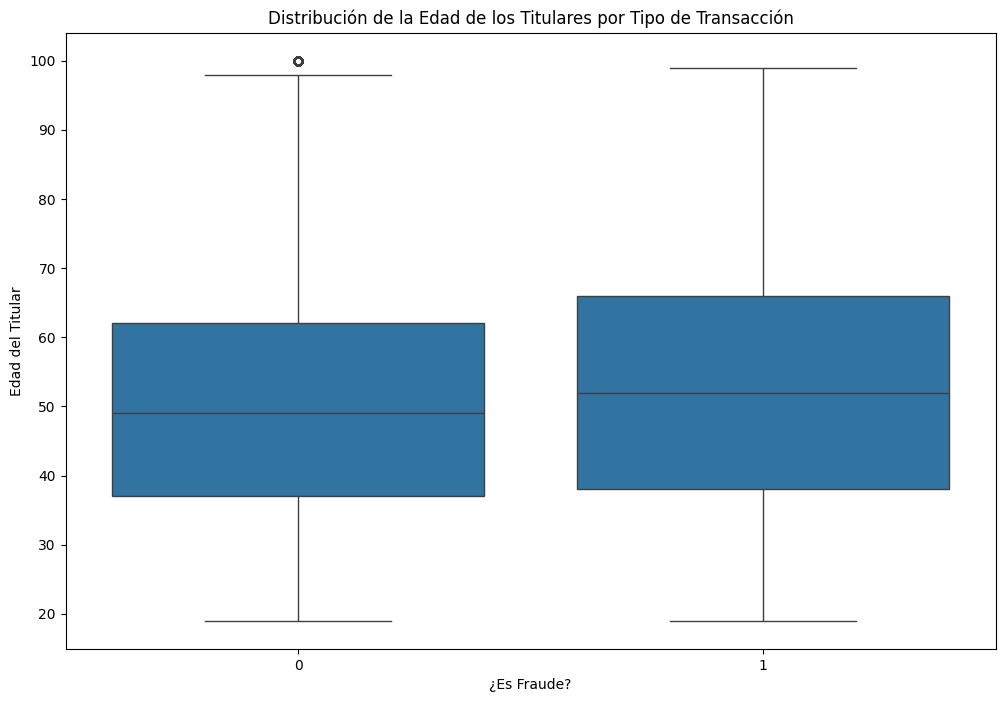

In [6]:
#Calcular edad
df['dob'] = pd.to_datetime(df['dob'])
current_year = pd.to_datetime('today').year
df['age'] = current_year - df['dob'].dt.year

#Gráfico
plt.figure(figsize=(12, 8))
sns.boxplot(x='is_fraud', y='age', data=df)
plt.title('Distribución de la Edad de los Titulares por Tipo de Transacción')
plt.xlabel('¿Es Fraude?')
plt.ylabel('Edad del Titular')
plt.show()

Conclusiones
- Las distribuciones de edad para las transacciones fraudulentas y no fraudulentas son bastante similares. Las medianas (las líneas horizontales en el interior de las cajas) están en torno a los 50 años tanto para fraudes como para no fraudes, lo que indica que la edad media de los titulares involucrados en fraudes no es significativamente diferente de la de los titulares en general.
- El rango de edades (indicado por la extensión de las cajas y las líneas de los bigotes) es bastante amplio en ambos casos, y no hay una concentración notable de fraudes en un grupo de edad específico. Los bigotes muestran que los fraudes se distribuyen a través de casi todo el rango de edades, desde los 20 hasta los 90 años.
- La hipótesis de que las transacciones de titulares jóvenes son más susceptibles a fraudes no parece estar respaldada por este gráfico. La distribución de edades para las transacciones fraudulentas no muestra una diferencia significativa respecto a las transacciones no fraudulentas, lo que sugiere que la edad no es un factor determinante en la susceptibilidad al fraude en este conjunto de datos.